# Load Libraries

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from model import UNet
from dataloader import ProstateDataset
from utils import ToTensor, plot_images, visualize_predictions, save_model, load_model
import os
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.distributed as dist

# Set the environment variable to use GPU 1
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available. Training on GPU.


# Load Dataset and Dataloader

In [3]:
# Initialize your dataset and dataloader
dataset = ProstateDataset(img_dir='./data/img', mask_dir='./data/mask', transform=ToTensor())

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.2 * len(dataset))  # 20% for validation
test_size = len(dataset) - train_size - valid_size  # Remaining 10% for testing

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# print(len(train_dataset), len(valid_dataset), len(test_dataset))

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Model

<img src="./U-Net_Model.PNG" alt="UNet Architecture" style="width:700px;"/>

In [6]:
# Initialize model
model = UNet(n_channels=1, n_classes=1)

from torchinfo import summary

# Assuming your model is already initialized
summary(model, input_size=(1, 1, 384, 384))  # Adjust input_size to match your model's input dimensions

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 384, 384]          --
├─DoubleConv: 1-1                             [1, 64, 384, 384]         --
│    └─Sequential: 2-1                        [1, 64, 384, 384]         --
│    │    └─Conv2d: 3-1                       [1, 64, 384, 384]         640
│    │    └─BatchNorm2d: 3-2                  [1, 64, 384, 384]         128
│    │    └─ReLU: 3-3                         [1, 64, 384, 384]         --
│    │    └─Conv2d: 3-4                       [1, 64, 384, 384]         36,928
│    │    └─BatchNorm2d: 3-5                  [1, 64, 384, 384]         128
│    │    └─ReLU: 3-6                         [1, 64, 384, 384]         --
├─Down: 1-2                                   [1, 128, 192, 192]        --
│    └─Sequential: 2-2                        [1, 128, 192, 192]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 192, 192]         --
│    │    └─D

In [8]:
model = torch.nn.DataParallel(model)  # Wrap the model with DataParallel
model = model.to(device)  # Move the model to the appropriate device

#### Output Size Calculation

Let’s say your input image has dimensions:

H_in × W_in = Height × Width


After applying `nn.Conv2d(...)`, the spatial dimensions **change**, depending on kernel size, padding, stride, etc.

The resulting **output feature map** has size:


The formulas to compute output dimensions are:

$$
H_{out} = \left\lfloor \frac{H_{in} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

$$
W_{out} = \left\lfloor \frac{W_{in} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

```python
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
H_in = 128, W_in = 128
```

$$
H_{out} = W_{out} = \left\lfloor \frac{128 + 2(1) - 3}{1} \right\rfloor + 1 = 128
$$

---

#### Parameter Calculation

Each convolutional filter has:

- `kernel_size × kernel_size × in_channels` weights  
- `+1` bias term per filter (optional, included by default)

---

For `mid_channels` output filters (a.k.a. `out_channels`):

$$
\text{Total Params} = (\text{in\_channels} \times 3 \times 3 + 1) \times \text{mid\_channels}
$$

More generally, for any kernel size `k × k`:

$$
\text{Total Params} = (\text{in\_channels} \times k \times k + 1) \times \text{out\_channels}
$$

---

```python
nn.Conv2d(16, 32, kernel_size=3, padding=1)
```

Params=(16×3×3+1)×32=(144+1)×32=4640

# Binary Cross-Entropy Loss

The Binary Cross-Entropy (BCE) loss measures the difference between the predicted probabilities and the true binary labels. It is defined as:

$$ \text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] $$

Where:

- $( y_i )$ is the ground truth label (0 or 1).
- $( p_i )$ is the predicted probability for the positive class.
- $( N )$ is the total number of samples.

This loss penalizes incorrect predictions more heavily when the predicted probability is far from the true label, encouraging the model to output probabilities closer to the true labels

The "WithLogits" part of BCEWithLogitsLoss means that this function combines two operations:

1. Sigmoid Activation: It applies the sigmoid function to the raw model outputs (logits) to convert them into probabilities in the range [0, 1].
2. Binary Cross-Entropy: It then computes the BCE loss using these probabilities.

In [9]:
# Loss function
criterion = torch.nn.BCEWithLogitsLoss()

# Optimizer

The optimizer is responsible for updating the model's parameters (weights and biases) during training to minimize the loss function.

Adam combines the benefits of two other optimizers:

- Momentum: Helps accelerate convergence by smoothing updates using a moving average of past gradients.
- RMSProp: Scales the learning rate for each parameter based on the magnitude of recent gradients, making it adaptive to different parameter scales.

Learning Rate, lr = 0.001

The lr argument specifies the learning rate, which controls the step size for updating the model's parameters.

In [10]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Phase

In [11]:
model = model.train()  # Set the model to training mode

num_epochs = 25

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        # Get the inputs and labels from the data loader
        inputs = batch['image'].to(device)
        labels = batch['mask'].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        # if i % 10 == 9:    # print every 10 mini-batches
        #     print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
        #     running_loss = 0.0

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}')

    # Validation phase
    model = model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(valid_loader):
            inputs = batch['image'].to(device)
            labels = batch['mask'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()

    valid_losses.append(valid_loss / len(valid_loader))
    print(f'Epoch {epoch + 1}, Validation Loss: {valid_losses[-1]:.4f}')
    model = model.train()  # Set the model back to training mode

Epoch 1, Training Loss: 0.3344
Epoch 1, Validation Loss: 0.1974
Epoch 2, Training Loss: 0.1564
Epoch 2, Validation Loss: 0.2226
Epoch 3, Training Loss: 0.1113
Epoch 3, Validation Loss: 0.0908
Epoch 4, Training Loss: 0.0778
Epoch 4, Validation Loss: 0.0618
Epoch 5, Training Loss: 0.0564
Epoch 5, Validation Loss: 0.0567
Epoch 6, Training Loss: 0.0449
Epoch 6, Validation Loss: 0.0496
Epoch 7, Training Loss: 0.0373
Epoch 7, Validation Loss: 0.0339
Epoch 8, Training Loss: 0.0316
Epoch 8, Validation Loss: 0.0305
Epoch 9, Training Loss: 0.0287
Epoch 9, Validation Loss: 0.0301
Epoch 10, Training Loss: 0.0266
Epoch 10, Validation Loss: 0.0383
Epoch 11, Training Loss: 0.0256
Epoch 11, Validation Loss: 0.0242
Epoch 12, Training Loss: 0.0222
Epoch 12, Validation Loss: 0.0267
Epoch 13, Training Loss: 0.0216
Epoch 13, Validation Loss: 0.0224
Epoch 14, Training Loss: 0.0209
Epoch 14, Validation Loss: 0.0226
Epoch 15, Training Loss: 0.0183
Epoch 15, Validation Loss: 0.0348
Epoch 16, Training Loss: 0.0

# Loss Curves (Batch Size 4 without Dataparallel)

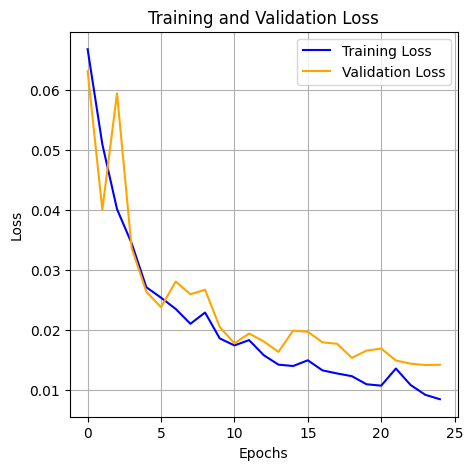

In [25]:
# Combine training and validation losses in a single plot
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

## 📉 Analysis of Training and Validation Loss Curves

The training and validation loss curves in your plot look **healthy and well-behaved overall**. Here's a breakdown of observations:

---

### ✅ **Positive Signs**

- **Both losses are decreasing** over time → indicating the model is learning.
- **Training loss continues to decline smoothly**, suggesting effective gradient updates.
- **Validation loss also decreases and stabilizes**, indicating good generalization to unseen data.
- There is **no significant overfitting**: the validation loss does not increase while training loss decreases.

---

### 📉 **Minor Observations**

- The validation loss has a few **small oscillations** (especially early on), which is common and not alarming.
- The **gap between training and validation loss** is modest, which is expected — training loss is often lower since the model is directly optimized for it.

---

### 📌 **Conclusion**

Your model is **training successfully and generalizing well**. You can consider:

- Implementing **early stopping** if validation loss plateaus for multiple epochs.
- Applying **learning rate decay** or scheduling to fine-tune the optimization further.


### Loss Curves (Batch Size - 16, Data Parallel)

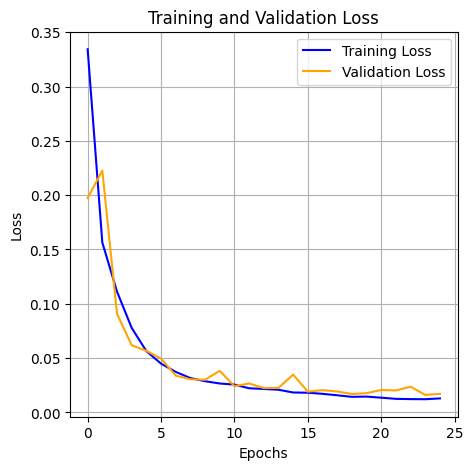

In [12]:
# Combine training and validation losses in a single plot
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

In [ ]:
# save model
save_model(model, 'model_unet.pth')

In [ ]:
# Delete variables
del model

# Clear GPU cache
torch.cuda.empty_cache()